In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing the data into arrays
# first column of the data file is phase data
PTO_PhaseHalf = np.loadtxt("GD356PTO.dat", usecols=(0))
PTO_Phase = np.concatenate((PTO_PhaseHalf, PTO_PhaseHalf+1))
# second column of the data file is flux data
PTO_FluxHalf = np.loadtxt("GD356PTO.dat", usecols=(1))
PTO_Flux = np.concatenate((PTO_FluxHalf+1, PTO_FluxHalf+1))
# third column of the data file is flux error
PTO_ErrorHalf = np.loadtxt("GD356PTO.dat", usecols=(2))
PTO_Error = np.concatenate((PTO_ErrorHalf, PTO_ErrorHalf))

In [3]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

meanPhase, meanFlux, meanError = mean_data(PTO_Phase, PTO_Flux, PTO_Error, 200)

In [4]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
import theano.tensor as tt

starry.config.lazy = True
starry.config.quiet = True

In [8]:
flux = meanFlux
flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

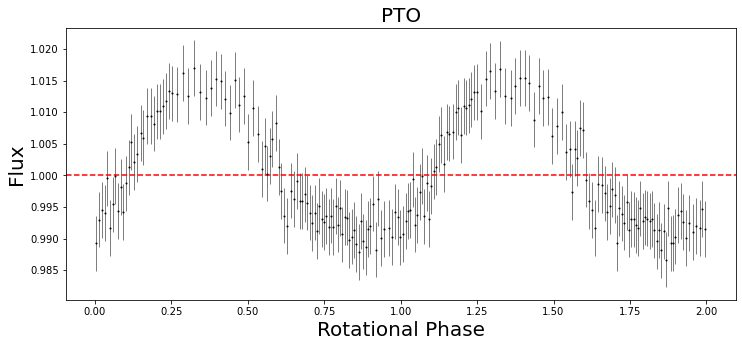

In [9]:
plt.figure(figsize=(12, 5))

plt.title('PTO', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# Medium Radius

In [10]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=0.12, testval=0.1)
    radius = pm.Uniform("radius", lower=20.0, upper=60.0, testval=30.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)

    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [11]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Optimization terminated successfully.
logp: 509.0511278208916 -> 853.0766958170655


In [12]:
keys = ["contrast", "radius", "lat", "lon", "inc"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.10213
radius       42.14680
lat          58.95882
lon          51.62596
inc          29.84741


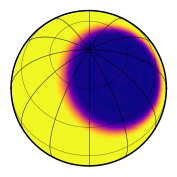

In [13]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.10213, radius=42.14680, lat=58.95882, lon=51.62596)
map.inc = 29.84741
map.show()

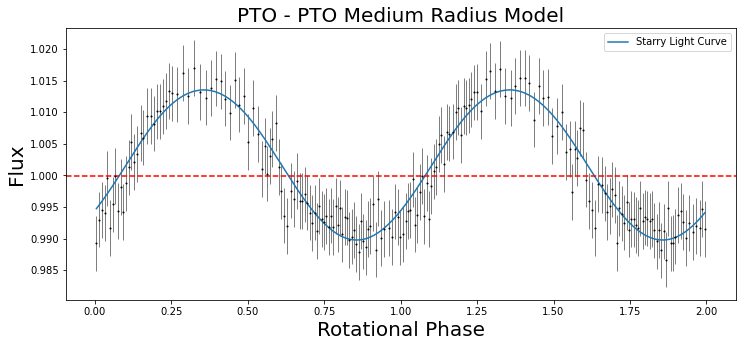

In [14]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('PTO - PTO Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [15]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

0.4068543418558882

# Large Radius

In [19]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=0.12, testval=0.1)
    radius = pm.Uniform("radius", lower=60.0, upper=90.0, testval=80.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [17]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Optimization terminated successfully.
logp: 511.2248185102533 -> 852.5690124582601


In [18]:
keys = ["contrast", "radius", "lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.05747
radius       87.72168
lat         -59.28193
lon          51.62840
inc          56.95332


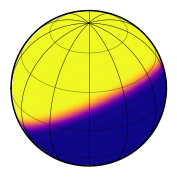

In [20]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.05747, radius=87.72168, lat=-59.28193, lon=51.62840)
map.inc = 56.95332
map.show()

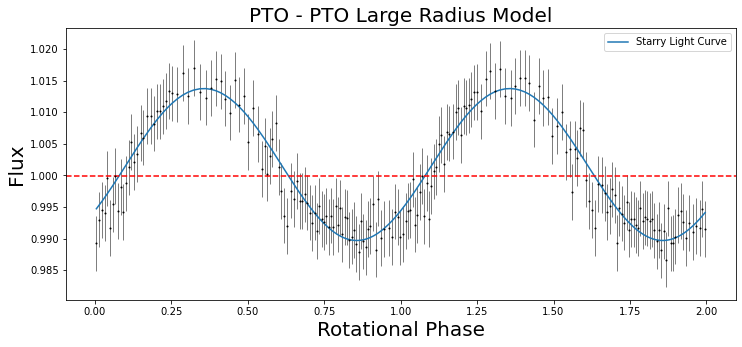

In [21]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('PTO - PTO Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [22]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

0.4062169626636702

In [11]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.011792567690129763

# TESS - Small Radius

In [15]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 8.15839
    lat = 47.47122
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 41.11102
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [16]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -5.497086890957275 -> 729.8631823342729


In [17]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.99861
lon          51.71382


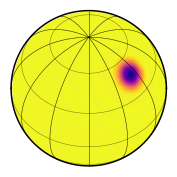

In [18]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.99861, radius=8.15839, lat=47.47122, lon=51.71382)
map.inc = 41.11102
map.show()

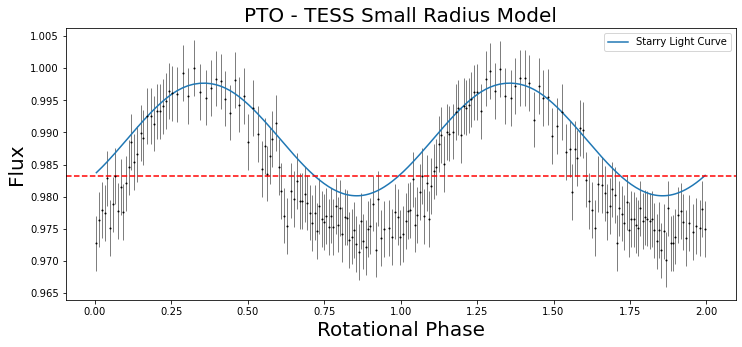

In [19]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('PTO - TESS Small Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [21]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

1.6429596210616462

# TESS - Medium Radius

In [22]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 20.52788
    lat = 47.71131
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 41.76645
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [23]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -2583.720872769618 -> 861.2468646814326


In [24]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.22019
lon          51.56763


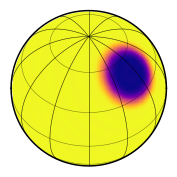

In [25]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.22019, radius=20.52788, lat=47.71131, lon=51.56763)
map.inc = 41.76645
map.show()

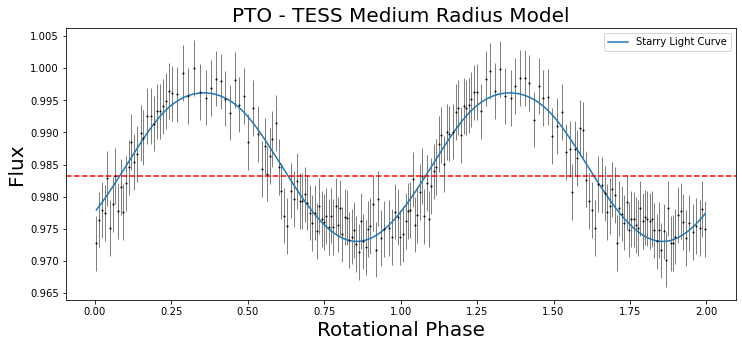

In [26]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('PTO - TESS Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [28]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

0.3965426841446885

# TESS - Large Radius

In [29]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 89.64379
    lat = -44.26156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.04429
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [30]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -45152.200863030776 -> 861.6367991209847


In [31]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.08313
lon          51.67330


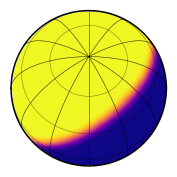

In [32]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.08313, radius=89.64379, lat=-44.26156, lon=51.67330)
map.inc = 24.04429
map.show()

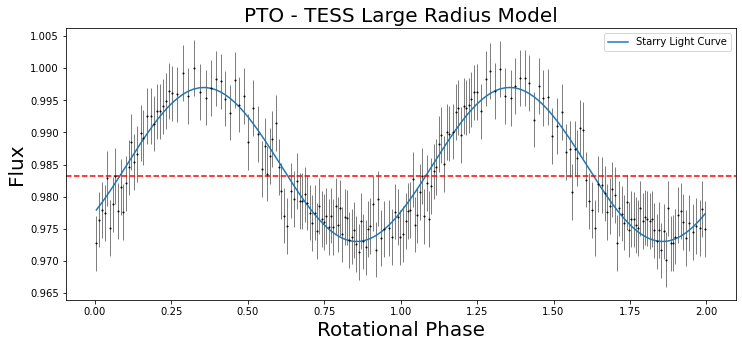

In [33]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('PTO - TESS Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [34]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

0.3838046792608498

In [35]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.011979165578823225

# LT - Medium Radius

In [36]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 21.43014
    lat = 48.30740
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 40.38516
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [37]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -3703.6195375631364 -> 860.4041387793903


In [38]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.20038
lon          51.75902


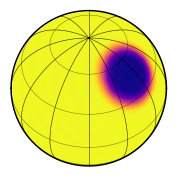

In [39]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.20038, radius=21.43014, lat=48.30740, lon=51.75902)
map.inc = 40.38516
map.show()

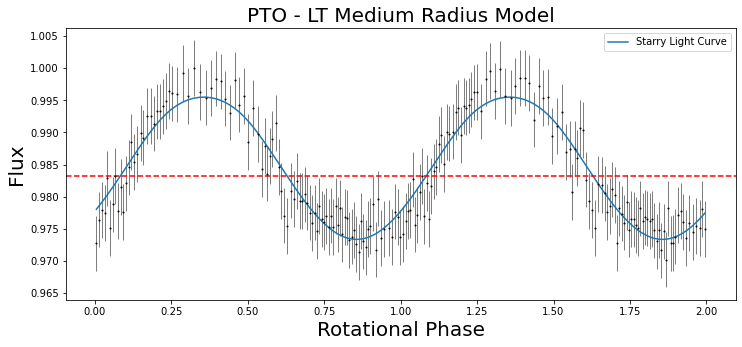

In [40]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('PTO - LT Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [41]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

0.40543176587152624

# LT - Large Radius

In [42]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 88.96745
    lat = -42.93086
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 21.40506
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [43]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -40705.23417737591 -> 860.5426927521139


In [44]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.08672
lon          51.85701


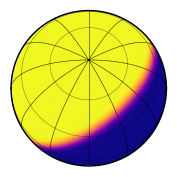

In [45]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.08672, radius=88.96745, lat=-42.93086, lon=51.85701)
map.inc = 21.40506
map.show()

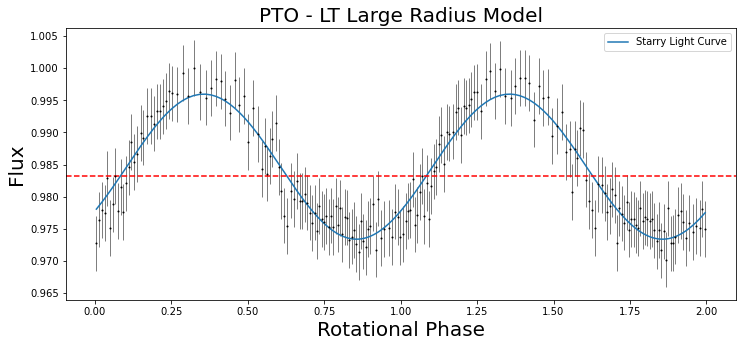

In [46]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('PTO - LT Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [47]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

0.3964380300344761

In [17]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.011284363319046586

# WHT - Small Radius

In [48]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 15.39599
    lat = 50.73618
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 34.22757
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [49]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 280.2631008456194 -> 839.9723906909818


In [50]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.35890
lon          52.60548


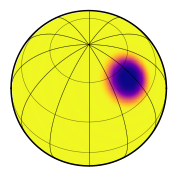

In [51]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.35890, radius=15.39599, lat=50.73618, lon=52.60548)
map.inc = 34.22757
map.show()

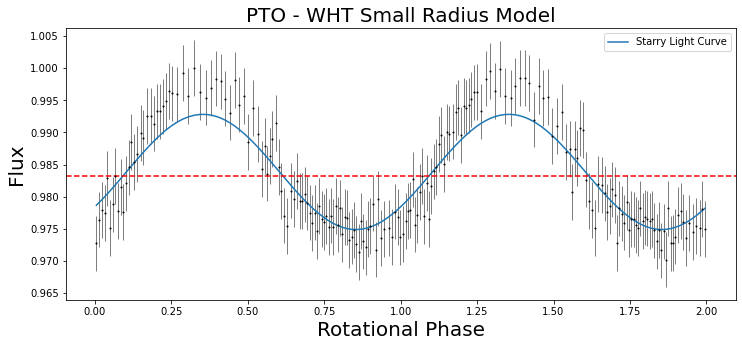

In [52]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('PTO - WHT Small Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [53]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

0.6213415788916022

In [20]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.00893431060081007

# WHT - Medium Radius

In [54]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 22.15108
    lat = 52.69509
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 36.21473
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [55]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -5516.682669164396 -> 839.2943588747785


In [56]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.17731
lon          52.58177


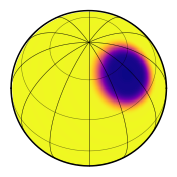

In [57]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.17731, radius=22.15108, lat=52.69509, lon=52.58177)
map.inc = 36.21473
map.show()

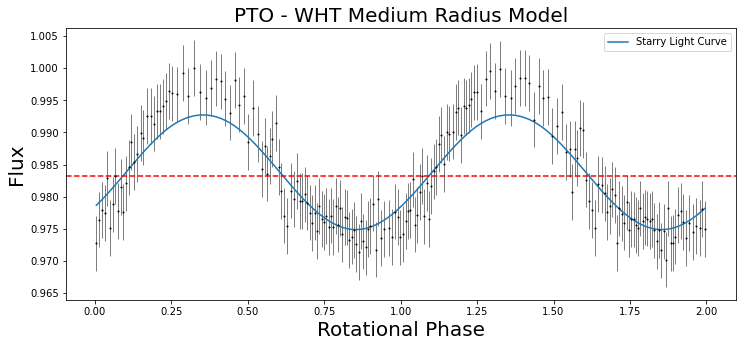

In [58]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('PTO - WHT Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [59]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

0.6238111419236638

# WHT - Large Radius

In [60]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 88.75199
    lat = -30.72870
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 19.14318
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [61]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -79425.64035587726 -> 838.5716239973193


In [62]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.06501
lon          52.57098


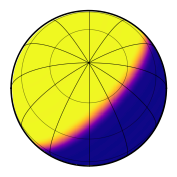

In [63]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.06501, radius=88.75199, lat=-30.72870, lon=52.57098)
map.inc = 19.14318
map.show()

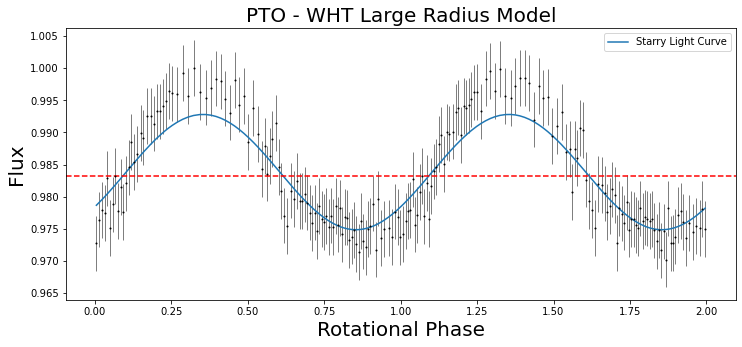

In [64]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('PTO - WHT Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [65]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

0.622170615043864

In [23]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.008940980088401107

# Brinkworth 2004 

In [61]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 40
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=30.0)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=45.0)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=1.4)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [62]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, contrast]


message: Optimization terminated successfully.
logp: -40780.15042739533 -> 847.0133587123784


In [64]:
keys = ["contrast", "lat", "lon", "inc"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.31207
lat          -6.42770
lon          50.88692
inc          12.05867


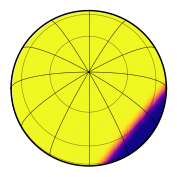

In [24]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.31207, radius=40, lat=-6.42770, lon=50.88692)
map.inc = 12.05867
map.show()

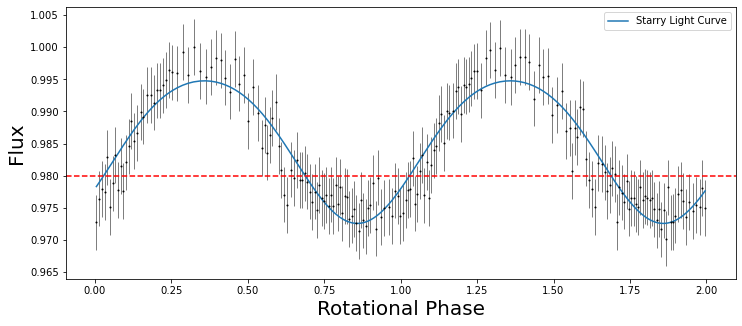

In [25]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.median(flux), color='r', linestyle='--');

In [67]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
chi_squared

99.2300890444231

In [26]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.011093347091087502